<img src="http://drive.google.com/uc?export=view&id=1tpOCamr9aWz817atPnyXus8w5gJ3mIts" width=500px>

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

#  Top-n list of restaurants on consumer preference

### INDUSTRY CASE STUDY - Popularity based + Collborative Filtering Based Recommendation system
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

## Case study problem statement:

### Context:

The dataset was obtained from a recommender system prototype. The task was to generate a top-n list of restaurants according to 
the consumer preferences.


### Input data details : https://archive.ics.uci.edu/ml/machine-learning-databases/00232/

(In here you will find rating_final.csv inside RCdata folder to be used)

### Expected output details: Restaurant recommendation system

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

### Steps

#### 1. Input libraries

#### 2. Data Analysis and preparation

#### 3. Popularity based Recommendation System

#### 4. Collaborative Filtering Recommendation System

#### 5. Insights

#### 6. Optional

### 1. Input libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 7.6 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619416 sha256=fffbb96e6e26e12a92ba7ee90d8cd4b1ad12ecf49d78cfc2df853ef82d40b38d
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

from surprise import Dataset 
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,classification_report

## 2. Data Analysis and preparation

### 2.1 Read the dataset and check info to understand the dataset

In [4]:
df = pd.read_csv("/content/drive/MyDrive/GL/RecommendationLab/restaurant+rating_final.csv")

In [7]:
df.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


### 2.2 Check statistical summary and write your observations

In [5]:
df.describe()

,placeID,rating,food_rating,service_rating
count,1161.000000,1161.000000,1161.000000,1161.000000
mean,134192.041344,1.199828,1.215332,1.090439
std,1100.916275,0.773282,0.792294,0.790844
min,132560.000000,0.000000,0.000000,0.000000
25%,132856.000000,1.000000,1.000000,0.000000
50%,135030.000000,1.000000,1.000000,1.000000
75%,135059.000000,2.000000,2.000000,2.000000
max,135109.000000,2.000000,2.000000,2.000000


### 2.3 Check if there are any missing values

In [6]:
df.isna().sum()

userID            0
placeID           0
rating            0
food_rating       0
service_rating    0
dtype: int64

### 2.4 Check minimum and maximum values for rating feature. Display its frequency distribution using appropriate graph

In [8]:
df['rating'].min()

0

In [9]:
df['rating'].max()

2

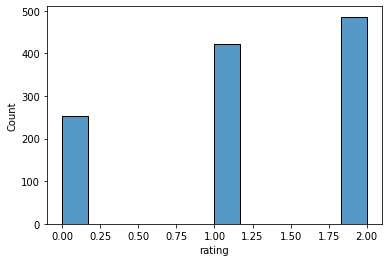

In [11]:
sns.histplot(df['rating'])

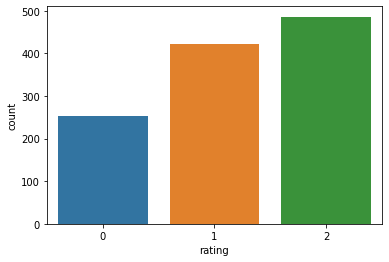

In [12]:
sns.countplot(df['rating'])

### 2.5 Check number of unique users and items (places) in the data

In [20]:
df['userID'].nunique()

138

In [22]:
df['placeID'].nunique()

130

### 2.6 Sort users by their number of ratings and display top 10 users who have given most number of ratings

In [26]:
df.groupby('userID').size().sort_values(ascending = False).head(10)

userID
U1061    18
U1106    18
U1134    16
U1024    15
U1022    14
U1089    14
U1137    14
U1135    14
U1003    13
U1016    13
dtype: int64

### 2.7. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 5 or more number of ratings). Report shape of the final dataset

In [27]:
counts = df['userID'].value_counts()

In [28]:
counts[counts>=5].index

Index(['U1061', 'U1106', 'U1134', 'U1024', 'U1089', 'U1022', 'U1137', 'U1135',
       'U1071', 'U1003',
       ...
       'U1044', 'U1043', 'U1076', 'U1012', 'U1102', 'U1026', 'U1077', 'U1042',
       'U1063', 'U1066'],
      dtype='object', length=115)

In [30]:
df_final =  df[df['userID'].isin(counts[counts>=5].index)]
df_final.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


### 2.8 Check number of unique users and items in the dataset

In [31]:
df_final['userID'].nunique()

115

In [32]:
df_final['placeID'].nunique()

129

## 3. Popularity Recommender model. (Non-personalised)

### 3.1 Check count of user_id for each unique product and save it as score 

In [35]:
data = df_final.groupby('placeID').agg({'userID':'count'}).reset_index()
data.head()

,placeID,userID
0,132560,4
1,132561,2
2,132564,1
3,132572,15
4,132583,4


In [36]:
# 
data.rename(columns={'userID':'score'}, inplace=True)
data.head()

,placeID,score
0,132560,4
1,132561,2
2,132564,1
3,132572,15
4,132583,4


### 3.2 Sort the products based on the score (calculated above)

In [38]:
data_sorted = data.sort_values(['score'], ascending=False).reset_index()

data_sorted

,index,placeID,score
0,122,135085,36
1,30,132825,32
2,79,135032,28
3,32,132834,25
4,97,135052,25
...,...,...,...
124,62,134987,2
125,17,132668,1
126,19,132715,1
127,2,132564,1


In [39]:
#drop the original index column, its not necessary 

data_sorted = data_sorted.drop(['index'], axis=1)
data_sorted.head()

,placeID,score
0,135085,36
1,132825,32
2,135032,28
3,132834,25
4,135052,25


### 3.3 Create a new column called 'Rank' having the ascending recommendation rank based upon score 

In [42]:
## using 'dense' is the correct way, but for this situation, we dont want to display more than needed 
## data, so going for 'first'

data_sorted['Rank'] = data_sorted['score'].rank(method = 'first', ascending=0)
data_sorted.head()

,placeID,score,Rank
0,135085,36,1.0
1,132825,32,2.0
2,135032,28,3.0
3,132834,25,4.0
4,135052,25,5.0


### 3.4 Get the top 10 recommendation based on their rank

In [47]:
t_10 = input("Enter the number of recommendations needed: ")
t_10 = int(t_10)

Enter the number of recommendations needed: 3


In [48]:
data_sorted['placeID'].head(t_10)

0    135085
1    132825
2    135032
Name: placeID, dtype: int64

## 4. Collaborative Filtering model

### 4.1 Define rating scale and convert dataframe into surprise dataset

In [49]:
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale = (0,2))

data = Dataset.load_from_df(df_final[['userID', 'placeID', 'rating']], reader)

data

### 4.2 Split the above surprise dataset into train and test set using surprise split function

In [51]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.20, random_state=1)


### 4.3 Print size of train and test set

In [55]:
## size of the test set
print(len(testset))

216


In [57]:
## size of the train set


trainset.n_ratings

863

In [ ]:
## code to find whats inside the train set in surprise....for future use, not for this lab
## didnt run this code..

userID = []
placeID = []
ratings = []

for(uid,iid,rating) in trainset.all_ratings():
  userID.append(trainset.to_raw_uid(uid))
  placeID.append(trainset.to_raw_iid(iid))
  ratings.append(rating)
dict = {'userID' : userID, 'placeID' : placeID, 'rating' : ratings}
training_df = pd.DataFrame(dict)

### 4.4 Build a default SVd model using train set

In [58]:
from surprise import SVD

svd_model = SVD(random_state=1)
svd_model.fit(trainset)

### 4.5 Make prediction for test set and convert test prediction into a dataframe

In [60]:
## The below step is just to predict the train dataset, we are converting the train dataset to 
## a list, so they can iterate over it.....build_testset() is used to convert the train set
## to a list 

train_pred = svd_model.test(trainset.build_testset())


test_pred = svd_model.test(testset)

In [61]:
pred_df = pd.DataFrame(test_pred)
pred_df.head()

,uid,iid,r_ui,est,details
0,U1114,132951,0.0,0.626474,{'was_impossible': False}
1,U1081,135032,0.0,1.075265,{'was_impossible': False}
2,U1111,135071,2.0,0.897919,{'was_impossible': False}
3,U1068,132660,0.0,1.050661,{'was_impossible': False}
4,U1111,132851,2.0,1.209243,{'was_impossible': False}


### 4.6 Check RMSe and MAE of train and test predictions

In [62]:
## checking how accurate predicted versus real ratings

print("Train RMSE: ", accuracy.rmse(train_pred))
print("Test RMSE: ", accuracy.rmse(test_pred))


RMSE: 0.4717
Train RMSE:  0.4717165699771339
RMSE: 0.6527
Test RMSE:  0.6527315055033774


In [63]:
print("Train MAE: ", accuracy.mae(train_pred))
print("Test MAE: ", accuracy.mae(test_pred))

MAE:  0.3935
Train MAE:  0.39351459152848406
MAE:  0.5576
Test MAE:  0.5576395787385812


### 4.7 Write a function to make top n recommendation to a user. The function should take a userID, data, and n as input arguments

In [64]:
pred_df.head()


,uid,iid,r_ui,est,details
0,U1114,132951,0.0,0.626474,{'was_impossible': False}
1,U1081,135032,0.0,1.075265,{'was_impossible': False}
2,U1111,135071,2.0,0.897919,{'was_impossible': False}
3,U1068,132660,0.0,1.050661,{'was_impossible': False}
4,U1111,132851,2.0,1.209243,{'was_impossible': False}


In [65]:
from collections import defaultdict
## default dict is a dictionary, but this wont throw a key error ..

In [68]:
def top_n(preds, userid, n):
  # first map the preds to each user

  top_n = defaultdict(list)
  for uid, iid, r_ui, est, details in preds:
    top_n[uid].append((iid, est))

  # then sort the preds for each user and retrieve top ratings 

  for uid, user_ratings, in top_n.items():
    user_ratings.sort(key = lambda X:X[1], reverse = True)
    top_n[uid] = user_ratings[:n]

  return top_n[userid]


### 4.8 Check top 3 recommendations for userID:- 'U1028'

In [69]:
top_n(test_pred, 'U1028', 3)

[(132733, 1.2183808652159578),
 (132613, 1.0494688391898461),
 (132663, 0.9042142134647467)]

## 5. Summarize your insights

In [ ]:
## The data set might need more fine tuning. 
## The r_ui and est are way off the limits.  
## 

## Optional
### Use GridSearch CV to get the best parameters for SVD model

In [70]:
param = {'n_factors': list(range(20,200))}

tuner = GridSearchCV(SVD, param, measures = ['rmse'], cv = 5)

tuner.fit(data)

In [71]:
tuner.best_params['rmse']


{'n_factors': 20}

In [72]:
tuner.best_score['rmse']

0.6541994346241358